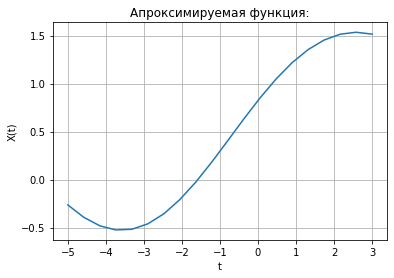

KeyboardInterrupt: 

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

class Model(object):
    def __init__(self, window_width):
        self.window_width = window_width
        self.w = np.zeros(self.window_width)
        self.w0 = 0
        self.x0 = 1
        self.initial_interval = np.zeros(0)
    def calculate(self, calculate_interval, norm, epochs):
        self.initial_interval = calculate_interval
        X = np.zeros(len(calculate_interval))
        for i in range(self.window_width):
            X[i] = calculate_interval[i]
        epochs_for_stats = epochs

        while epochs != 0:
            X_temp = X.copy()
            eps = 0

            for i in range(len(calculate_interval) - self.window_width):

                window = X_temp[i:i + self.window_width].copy()
                
                for j in range(self.window_width):
                    X_temp[i + self.window_width] += self.w[j]*window[j]
                X_temp[i + self.window_width] += self.w0*self.x0
                delta = calculate_interval[i + self.window_width] - X_temp[i + self.window_width]
                
                for k in range(self.window_width):
                    self.w[k] = self.w[k] + norm*delta*window[k]
                self.w0 = self.w0 + norm*delta*self.x0
                eps += delta**2
            epochs -= 1
        return math.sqrt(eps)

    def predict(self, predict_interval_len):

        predict_interval = np.zeros(predict_interval_len)
        full_interval = np.concatenate((self.initial_interval, predict_interval), axis=None)

        for i in range(predict_interval_len):
            window = full_interval[i + len(self.initial_interval) - self.window_width:i + len(self.initial_interval)]
            for j in range(self.window_width):
                full_interval[i + len(self.initial_interval)] += self.w[j]*window[j]
            full_interval[i + len(self.initial_interval)] += self.w0*self.x0
        
        return full_interval

def x(t):
    return 0.5*math.exp(0.5*math.cos(0.5*t))+math.sin(0.5*t)

def create_y_values(x_values):

    y_values = np.zeros(len(x_values))
    for i in range(len(x_values)):
        t = x_values[i]
        y_values[i] = x(t)

    return y_values

def RMSD(real_interval, predicted_interval):

    delta_sum = 0

    for i in range(len(real_interval)):
        delta = real_interval[i] - predicted_interval[i]
        delta_sum += delta**2
    
    eps = math.sqrt(delta_sum)
    
    return eps

def define_best_params(x_values_real, y_values_real):
    epoch_nums = np.linspace(4000, 5000, num=5)
    window_widths = np.linspace(4, 11, num=5)
    norms = np.linspace(0.15, 0.36, num=5)
    errors = np.zeros(0)

    for i in range(len(window_widths)):
        for j in range(len(norms)):
            for k in range(len(epoch_nums)):
                model = Model(window_width=int(window_widths[i]))
                model.calculate(calculate_interval=y_values_real[:20], norm=norms[j], epochs=epoch_nums[k])
                prediction = model.predict(predict_interval_len=20)

                err = RMSD(y_values_real[20:], prediction[20:])
                errors = np.append(errors, err)

                if err <= min(errors):
                    min_error = err
                    min_i = i
                    min_j = j
                    min_k = k

    print("Минимальная ошибка равна ", min_error, " при " + str(epoch_nums[min_k]) + "эпохах, норме обучения" + str(norms[min_j]) + " и размере окна " + str(window_widths[min_i]))

    model1 = Model(window_width=int(window_widths[min_i]))
    model1.calculate(calculate_interval=y_values_real[:20], norm=norms[min_j], epochs=epoch_nums[min_k])
    prediction1 = model1.predict(predict_interval_len=20)

    plt.plot(x_values_real, y_values_real, label='X(t)')
    plt.plot(x_values_real, prediction1, 'ro', label='x')
    plt.title("Исходная функция и её прогноз при " + str(epoch_nums[min_k]) + "эпохах, норме обучения" + str(norms[min_j]) + " и размере окна " + str(window_widths[min_i]))
    plt.xlabel("t")
    plt.ylabel("X(t), x")
    plt.legend()
    plt.grid()
    plt.show()

def main():

    x_values_real = np.linspace(-5, 3, num=20)
    y_values_real = create_y_values(x_values_real)
    plt.title("Апроксимируемая функция:")
    plt.xlabel("t")
    plt.ylabel("X(t)")
    plt.grid()
    plt.plot(x_values_real[:20], y_values_real[:20])
    plt.show()

    epoch_nums = np.linspace(50, 1000, num=10)
    
    errors = []
    for i in range(len(epoch_nums)):
        model = Model(window_width=5)
        err = model.calculate(calculate_interval=y_values_real[:20], norm=0.21, epochs=epoch_nums[i])
        errors.append(err)
    plt.title("Зависимость среднеквадратичной ошибки от кол-ва эпох")
    plt.xlabel("N")
    plt.ylabel("E")
    plt.grid()
    plt.semilogy(epoch_nums, errors)
    plt.show()   

    window_widths = np.linspace(2, 7, num=5)
    errors = []
    for i in range(len(window_widths)):
        model = Model(window_width=int(window_widths[i]))
        err = model.calculate(calculate_interval=y_values_real[:20], norm=0.21, epochs=600)
        errors.append(err)
    plt.title("Зависимость среднеквадратичной ошибки от ширины окна")
    plt.xlabel("p")
    plt.ylabel("E")
    plt.grid()
    plt.semilogy(window_widths, errors)
    plt.show()

    norms = np.linspace(0.1, 0.5, num=10)
    errors = []
    for i in range(len(norms)):
        model = Model(window_width=7)
        err = model.calculate(calculate_interval=y_values_real[:20], norm=norms[i], epochs=1000)
        errors.append(err)
    plt.title("Зависимость среднеквадратичной ошибки от нормы")
    plt.xlabel("n")
    plt.ylabel("E")
    plt.grid()
    plt.semilogy(norms, errors)
    plt.show()

    model2 = Model(window_width=int(6))
    model2.calculate(calculate_interval=y_values_real[:20], norm=0.3, epochs=2000)
    prediction2 = model2.predict(predict_interval_len=20)

    plt.plot(x_values_real, y_values_real, label='X(t)')
    plt.plot(x_values_real, prediction2, 'ro', label='x')
    plt.title("Исходная функция и её прогноз при 2000 эпохах, размере окна 6 и норме обучения 0.3")
    plt.xlabel("t")
    plt.ylabel("X(t), x")
    plt.legend()
    plt.grid()
    plt.show()

    define_best_params(x_values_real, y_values_real)

if __name__ == "__main__":
    main()
